# AGDTmini Demo

## Retrieve the metadata

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re

url = "https://raw.githubusercontent.com/nauarchus/AGDTmini/refs/heads/public/metadata/naps_morph_datasets_datesorted.csv"
df = pd.read_csv(url, dtype=str)

## Get a Big Picture of the Available Data

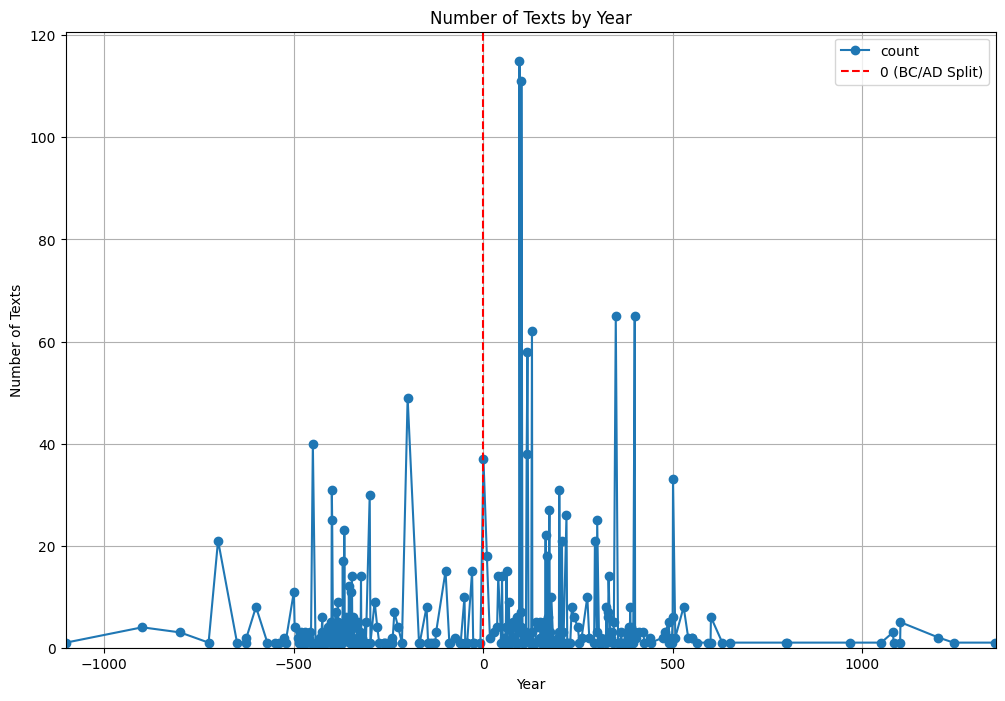

In [7]:
def extract_start_year(date_range):
    try:
        start_date = date_range.split('/')[0]
        start_date = re.sub(r'-(\d{4})-\d{2}', r'-\1', start_date)  # Handles "-YYYY-MM"
        start_date = re.sub(r'\+(\d{4})-\d{2}', r'\1', start_date)   # Handles "+YYYY-MM"
        if start_date.startswith('-'):
            start_date_lstripped = start_date  # Don't strip leading zeroes from negative years
        else:
            start_date_lstripped = start_date.lstrip('0')  # Strip leading zeroes only for positive years
        start_year = int(start_date_lstripped)
        return start_year
    except (ValueError, AttributeError):
        return None

df['start_year'] = df['formatted_work_date'].apply(extract_start_year)
df_cleaned = df.dropna(subset=['start_year'])

if not df_cleaned.empty:
    year_text_count = df_cleaned['start_year'].value_counts().sort_index(ascending=True)
    plt.figure(figsize=(12, 8))
    ax = year_text_count.plot(kind='line', marker='o')
    ax.axvline(x=0, color='red', linestyle='--', label="0 (BC/AD Split)")  # Vertical line at 0
    ax.set_xlim(min(year_text_count.index) - 1, max(year_text_count.index) + 1)  # Ensure the axis includes all years
    plt.title("Number of Texts by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Texts")
    plt.grid(True)
    ax.set_ylim(bottom=0)
    plt.legend()
    plt.show()
else:
    print("No valid year data available to plot.")

## Compare Two Works: Identify Two cts_urn Values to Compare

For example, two works attributed to Severian of Gabala: pta0001.pta041 & pta0001.pta042.

For different works, replace ['pta0001.pta041', 'pta0001.pta042'] with ['authorid.workid', 'authorid.workid']

In [8]:
cts_urn_values = ['pta0001.pta041', 'pta0001.pta042']

## Compare Two Works: Confirm Work Selection

In [9]:

filtered_df = df[df['cts_urn'].isin(cts_urn_values)]
pd.set_option('display.max_columns', None)  # Show all columns
if not filtered_df.empty:
    print(filtered_df)  # Show the full DataFrame
else:
    print("No rows found for the given cts_urn values.")


     formatted_work_date         cts_urn              author  \
1777   +0400-01/+0409-12  pta0001.pta041  Severian of Gabala   
1778   +0400-01/+0409-12  pta0001.pta042  Severian of Gabala   

                                     title  start_year  
1777  In illud: Quando ipsi subiciet omnia         400  
1778          In illud: Genimina viperarum         400  


## Pull and Parse the Work Data

In [10]:

def construct_raw_url(cts_urn):
    author, work = cts_urn.split('.')
    url = f"https://raw.githubusercontent.com/nauarchus/AGDTmini/public/data/{author}/{work}/{author}.{work}.agdtm-grc1.csv"
    return url

datasets = {}
for cts_urn in cts_urn_values:
    url = construct_raw_url(cts_urn)
    try:
        dataset = pd.read_csv(url, names=["location", "text"], header=None)
        datasets[cts_urn] = dataset
        print(f"Successfully retrieved data for {cts_urn}")
        print(dataset.head())
    except Exception as e:
        print(f"Failed to retrieve data for {cts_urn}: {e}")

Successfully retrieved data for pta0001.pta041
          location                                               text
0         location                                               text
1  ipsi.subiciet_1  χθές@d-------- ἐγώ@p1p---md- ἀδελφός@n-p---mv-...
2  ipsi.subiciet_2  ἀλλά@c-------- ’@c-------- ἐπεί@c-------- μέν@...
3  ipsi.subiciet_3  βιάζω@v-srpenn- φημί@v3spia--- ὁ@l-s---nn- ῥῆμ...
4  ipsi.subiciet_4  λαμβάνω@v2sama--- ἐγώ@p-s---md- καί@d-------- ...
Successfully retrieved data for pta0001.pta042
           location                                               text
0          location                                               text
1  Genim.viper._1.1  λαμπάς@n-s---fn- εὐσέβεια@n-s---fg- κήρυγμα@n-...
2  Genim.viper._1.2  ἔρχομαι@v1pasa--- τοίνυν@d-------- ἐπί@r------...
3  Genim.viper._1.3  εἰ@c-------- τοίνυν@d-------- σόδος@n-p---mg- ...
4  Genim.viper._1.4  ἀλλά@c-------- ’@c-------- εἰς@r-------- ὁ@l-s...


## Run a Simple Lemma Query: Raw, Frequencies, and Absolute Difference

In [11]:
lemma = "τοίνυν"
search_term = lemma + "@"
raw_counts = {}
frequencies = {}

for cts_urn, df in datasets.items():
    if df.iloc[0].tolist() == ["location", "text"]:
        df = df.iloc[1:]
    raw_count = df["text"].str.count(search_term).sum()
    total_tokens = df["text"].str.count("@").sum()
    frequency = (raw_count / total_tokens) * 100
    raw_counts[cts_urn] = raw_count
    frequencies[cts_urn] = frequency
    print(f"{cts_urn}: Raw count = {raw_count}, Frequency = {frequency:.2f}")

if len(frequencies) >= 2:
    urns = list(frequencies.keys())
    abs_diff = abs(frequencies[urns[0]] - frequencies[urns[1]])
    print(f"Absolute frequency difference between {urns[0]} and {urns[1]}: {abs_diff:.2f}")

pta0001.pta041: Raw count = 7, Frequency = 0.18
pta0001.pta042: Raw count = 6, Frequency = 0.07
Absolute frequency difference between pta0001.pta041 and pta0001.pta042: 0.10


## Run a Simple Morph Query: Raw Count, Frequencies, and Absolute Difference 

In [12]:
postag = "r"
search_term = "@" + postag
raw_counts = {}
frequencies = {}

for cts_urn, df in datasets.items():
    if df.iloc[0].tolist() == ["location", "text"]:
        df = df.iloc[1:]
    raw_count = df["text"].str.count(search_term).sum()
    total_tokens = df["text"].str.count("@").sum()
    frequency = (raw_count / total_tokens) * 100
    raw_counts[cts_urn] = raw_count
    frequencies[cts_urn] = frequency
    print(f"{cts_urn}: Raw count = {raw_count}, Frequency = {frequency:.2f}")

if len(frequencies) >= 2:
    urns = list(frequencies.keys())
    abs_diff = abs(frequencies[urns[0]] - frequencies[urns[1]])
    print(f"Absolute frequency difference between {urns[0]} and {urns[1]}: {abs_diff:.2f}")

pta0001.pta041: Raw count = 231, Frequency = 5.82
pta0001.pta042: Raw count = 485, Frequency = 5.91
Absolute frequency difference between pta0001.pta041 and pta0001.pta042: 0.09


## Run More Complex Regex Queries: Raw Count, Frequencies, and Absolute Difference

For this example, a multiword word finding "εἰ@c--------", followed immediately by any word with a "@d" (AGDT "ADP", aka "Adposition" or "Preposition") XPOS tag.

In [13]:
pattern = r"εἰ@c--------\s+\S+@d"
raw_counts = {}
frequencies = {}

for cts_urn, df in datasets.items():
    if df.iloc[0].tolist() == ["location", "text"]:
        df = df.iloc[1:]
    raw_count = df["text"].str.count(pattern).sum()
    total_tokens = df["text"].str.count("@").sum()
    frequency = (raw_count / total_tokens) * 100
    raw_counts[cts_urn] = raw_count
    frequencies[cts_urn] = frequency
    print(f"{cts_urn}: Raw count = {raw_count}, Frequency = {frequency:.2f}")

if len(frequencies) >= 2:
    urns = list(frequencies.keys())
    abs_diff = abs(frequencies[urns[0]] - frequencies[urns[1]])
    print(f"Absolute frequency difference between {urns[0]} and {urns[1]}: {abs_diff:.2f}")

pta0001.pta041: Raw count = 8, Frequency = 0.20
pta0001.pta042: Raw count = 23, Frequency = 0.28
Absolute frequency difference between pta0001.pta041 and pta0001.pta042: 0.08
